#  Прогнозирование заказов такси

Сервис такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нам нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`.  
Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).  

Проект выполнен в **Jupyter Notebook**, версия сервера блокнотов: 6.1.4. Версия **Python** 3.7.8.
В проекте использованы библиотеки: 
* **Pandas**
* **NumPy**
* **statsmodels**
* **scikit-learn**
* **MatPlotLib**
* **Light GBM**
* **IPython**

## Подготовка

In [1]:
pip install --user -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --user statsmodels==0.13.2

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Загружаем необходимые библиотеки и модули.
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
# Загружаем датасет.
preview_data = pd.read_csv('/datasets/taxi.csv')
# Изучаем основную информацию о датасете.
print('\033[1m' + 'Таблица № 1. Информация об исходном датасете')
preview_data.info()

Таблица № 1. Информация об исходном датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# Откроем датасет.
print('\033[1m' + 'Таблица № 2. Исходный датасет')
display(preview_data)

Таблица № 2. Исходный датасет


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [6]:
# Поищем дубликаты.
print('Количество полных дубликатов составляет', 
      preview_data.duplicated().sum())
print('Количество дубликатов в столбце datetime составляет', 
      preview_data.duplicated(subset=['datetime']).sum())

Количество полных дубликатов составляет 0
Количество дубликатов в столбце datetime составляет 0


Предварительно рассмотрев данные, загрузим датасет заново, учитывая необходимое изменение типа данных столбца datetime.

In [7]:
# Загружаем данные, учитывая тип данных и устновку новых индексов.
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
print('\033[1m' + 'Таблица № 3. Обновленный датасет')
display(data)

Таблица № 3. Обновленный датасет


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [8]:
# Изучаем основную информацию об обновленном датасете.
print('\033[1m' + 'Таблица № 4. Информация об исходном датасете')
data.info()

Таблица № 4. Информация об исходном датасете
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
# Проверяем хронологический порядок расположения индексов.
data = data.sort_index()
print(data.index.is_monotonic)

True


In [10]:
# Проводим ресемплирование по одному часу.
data = data.resample('1H').sum()
print('\033[1m' + 'Таблица № 5. Датасет после ресемплирования')
display(data)

Таблица № 5. Датасет после ресемплирования


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Вывод

Мы загрузили исходный датасет, проверили его на наличие дубликатов. Пропусков не обнаружено. Затем мы убедились в том, что данные расположены в хронологическом порядке и провели ресемплирование по одному часу. Отметим, что после ресемплирования в датасете стало 4416 объектов. Переходим к анализу данных.

## Анализ

Создадим функцию для графического анализа временных рядов.  
Затем построим график временного ряда с марта по август 2018 г.

In [11]:
# Объявляем функцию.
def time_series_describe(data):
    data.plot(
        kind='line',
        figsize=(16,5),
        grid=True
    )
    plt.xlabel('Дата и время')
    plt.ylabel('Количество заказов')
    plt.title('График количества заказов за заданный период времени')
    
    # Разбиваем на тренд, сезонность и шумы.
    decomposed = seasonal_decompose(data['num_orders'])
    plt.figure(figsize=(16,9))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.xlabel('Дата и время')
    plt.ylabel('Количество заказов')
    plt.subplot(312) 
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.xlabel('Дата и время')
    plt.ylabel('Количество заказов')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.xlabel('Дата и время')
    plt.ylabel('Количество заказов')
    plt.tight_layout()

In [12]:
# Сгладим колебания временного ряда.
data_copy = data.copy()
data_copy['rolling_mean'] = data_copy.rolling(10).mean()
# Избавимся от NaN-значений.
data_nona = data_copy.dropna()

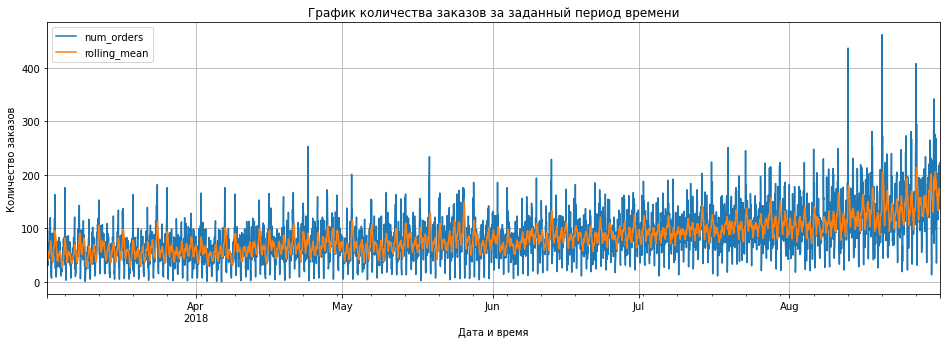

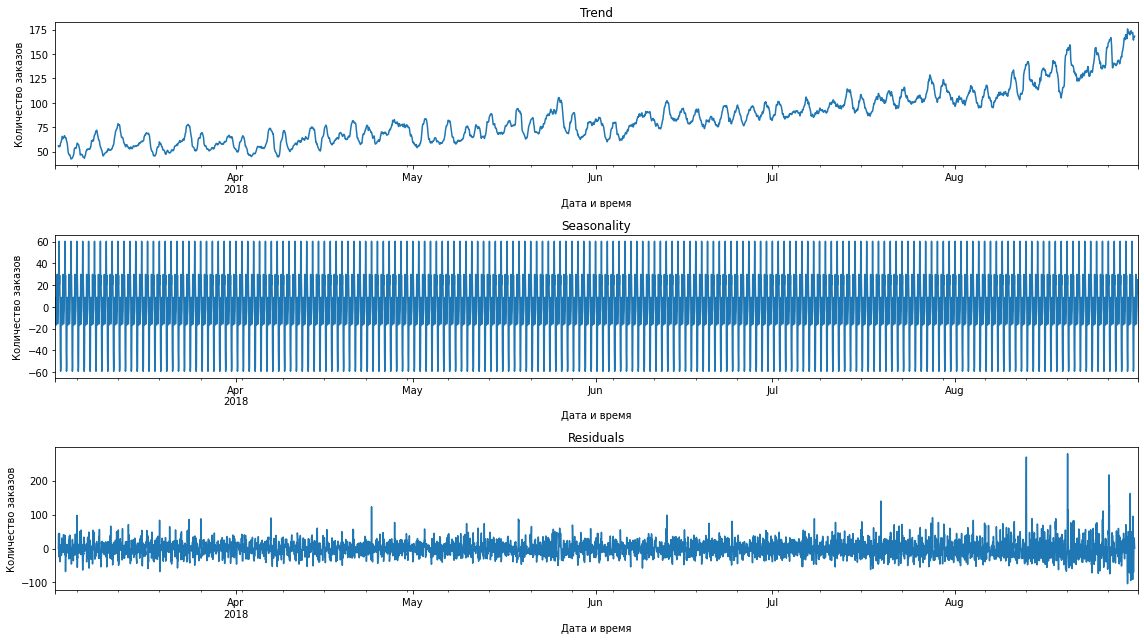

In [13]:
# Изучим период с марта по август 2018 г.
time_series_describe(data_nona)

Проанализировав график временного ряда с марта по август можно сделать следующий вывод.
Существует однозначный тренд на увеличение среднего числа заказов с течением времени. Начиная с середины апреля среднее число заказов растёт. Теперь рассмотрим более короткие периоды. Например, апрель.

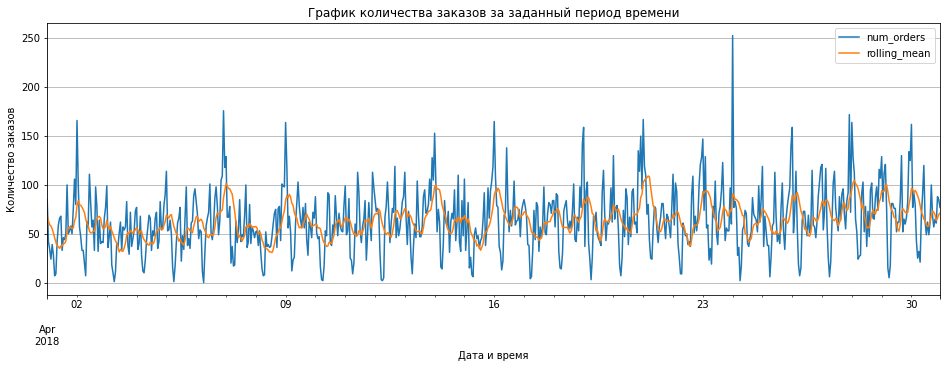

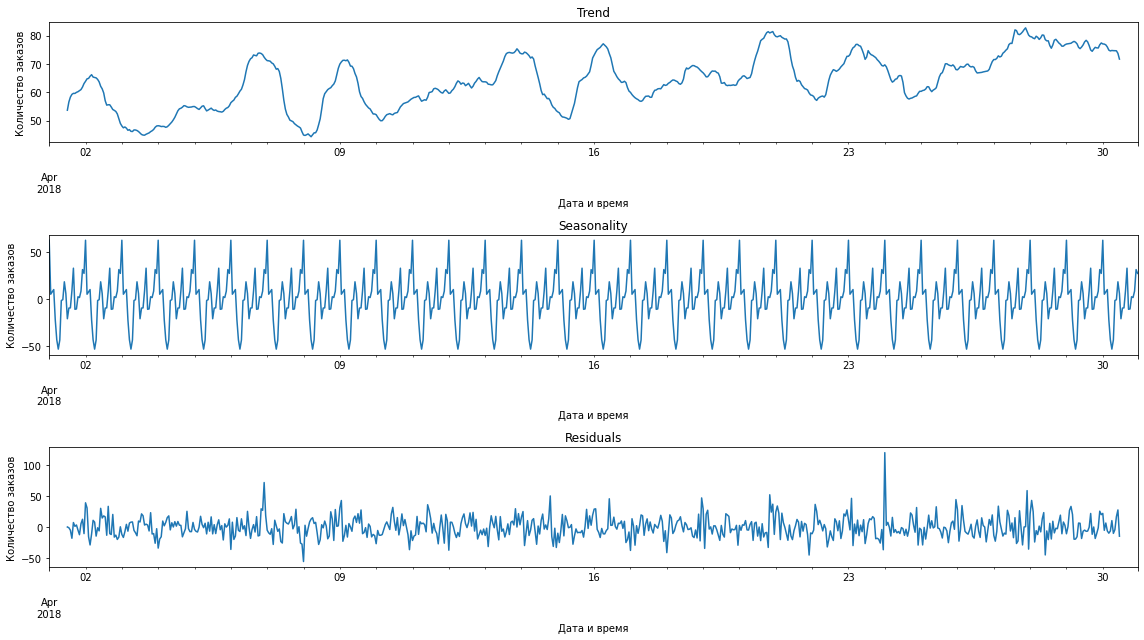

In [14]:
april = data_nona['2018-04-01':'2018-04-30']
time_series_describe(april)

Проанализировав графики временного ряда за апрель 2018 г., можно сделать вывод, что максимальные значения количества заказов достигаются в период с воскресенья по понедельник и в период между пятницей-субботой. При этом мы также отмечаем тренд на общее увеличение количества заказов в течение апреля. Рассмотрим неделю апреля с 9 по 16 апреля.

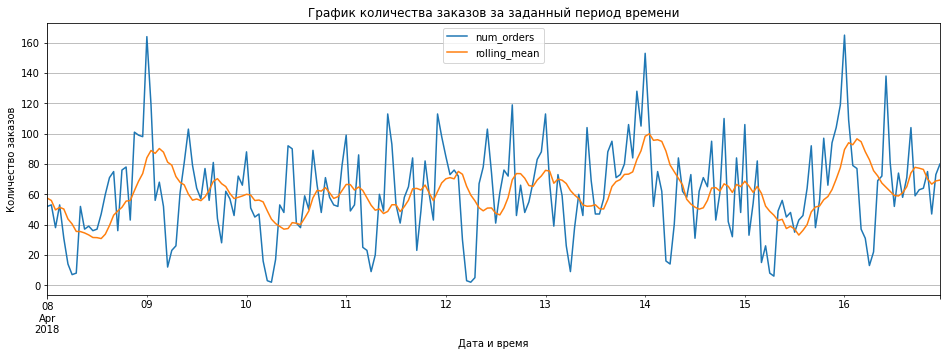

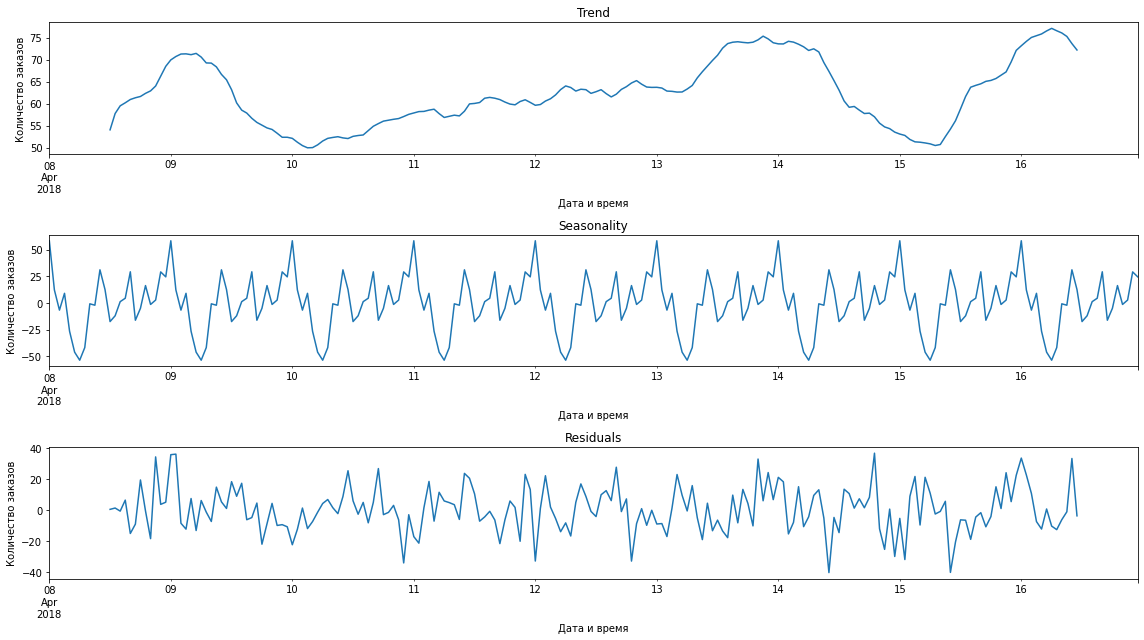

In [15]:
april = data_nona['2018-04-08':'2018-04-16']
time_series_describe(april)

Рассмотрев данные за неделю, мы отмечаем, что есть сезонность в количестве заказов в части времени суток. Ночью количество заказов уменьшается. После 12 часов дня количество заказов растёт. Теперь рассмотрим три дня любой недели апреля: среда, пятница, воскресенье.

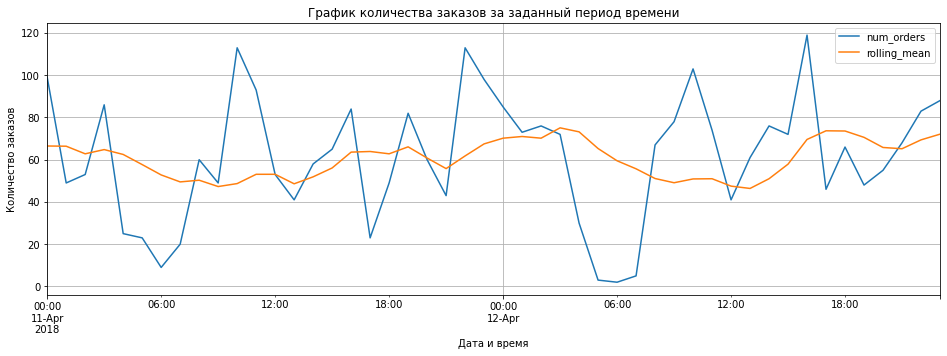

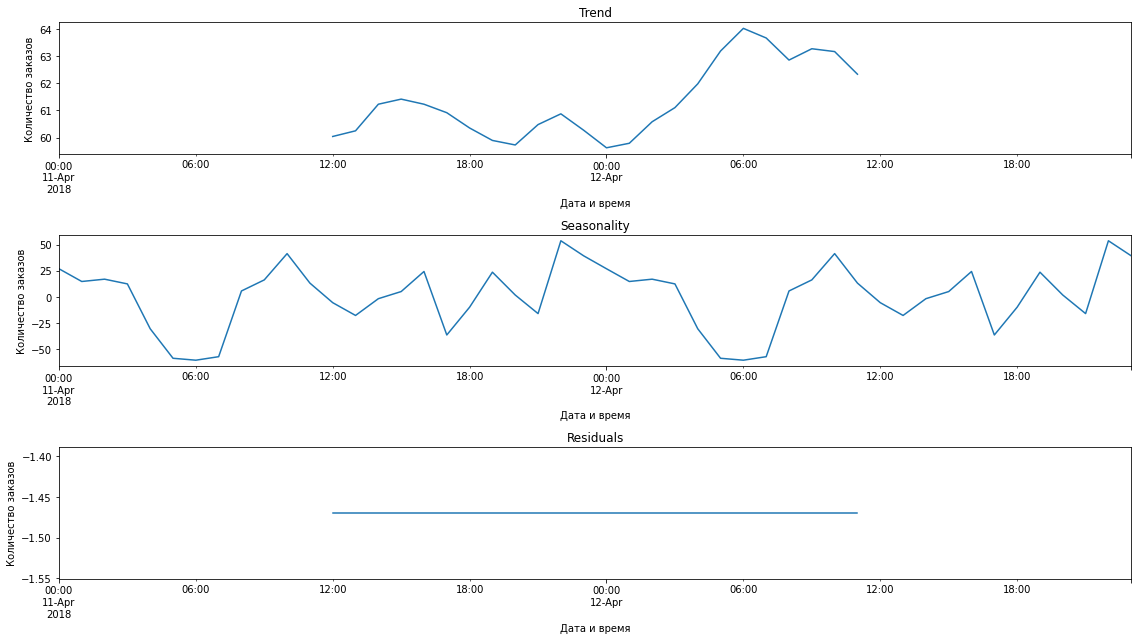

In [16]:
wednesday = data_nona['2018-04-11':'2018-04-12']
time_series_describe(wednesday)

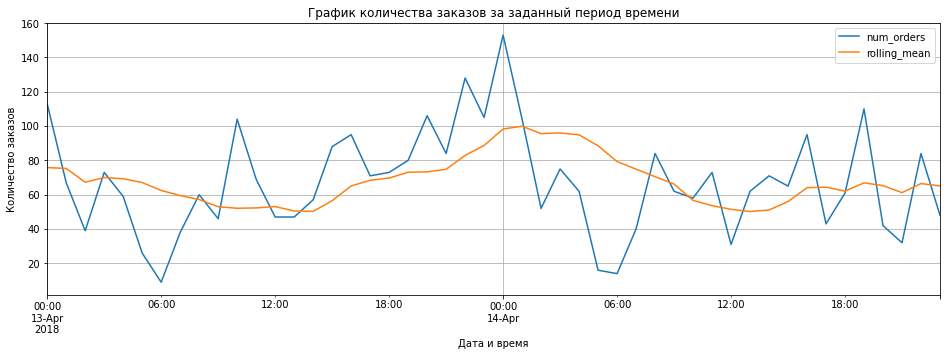

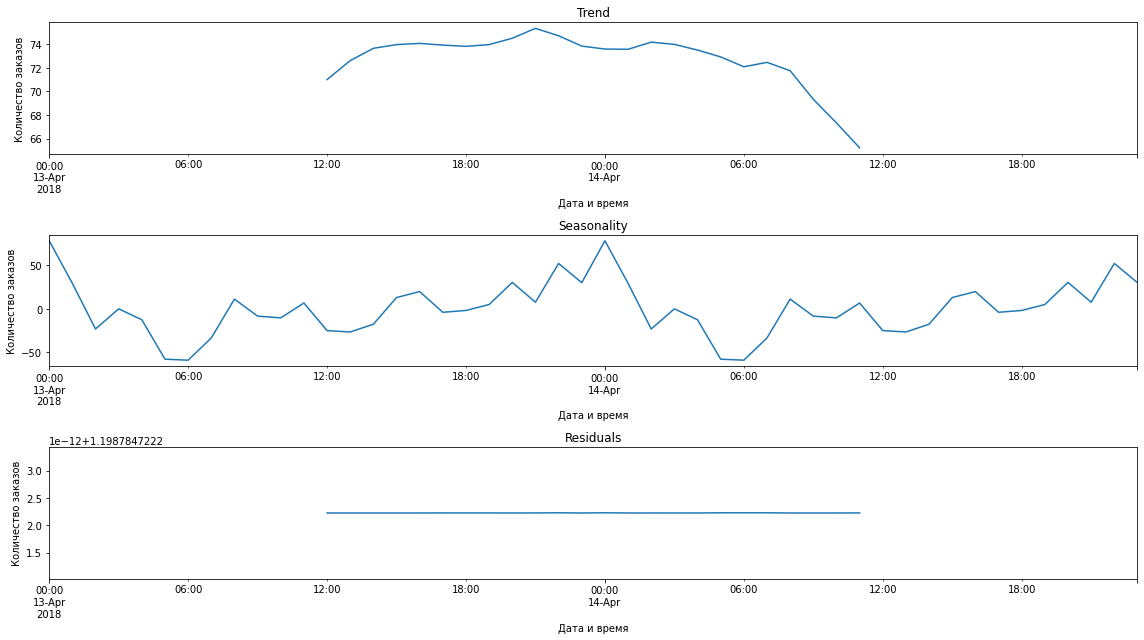

In [17]:
friday = data_nona['2018-04-13':'2018-04-14']
time_series_describe(friday)

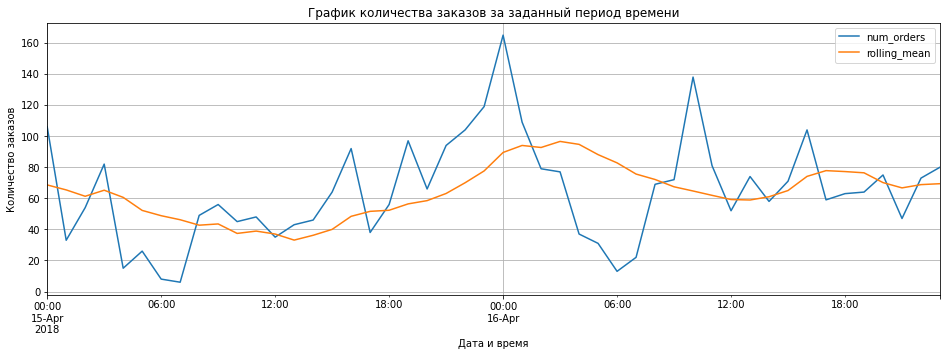

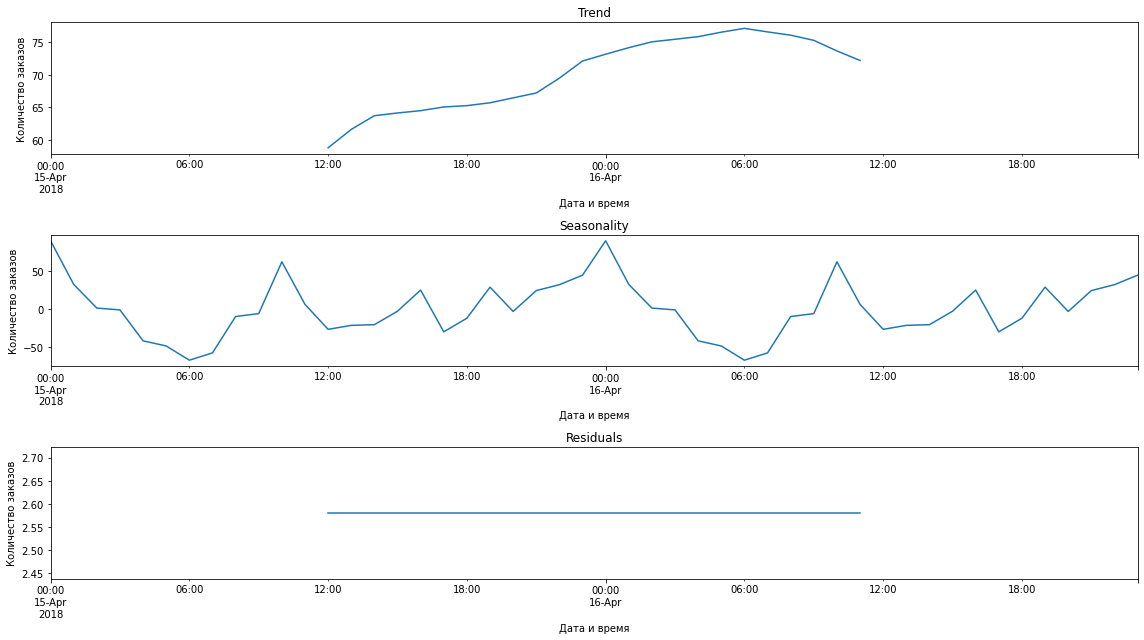

In [18]:
sunday = data_nona['2018-04-15':'2018-04-16']
time_series_describe(sunday)

Анализ трех наиболее показательных дней недели выявил сезонную закономерность: примерно с 13-14 часов дня начинается увеличение запросов на такси. Увеличение заканчивается примерно в 1-3 ночи. Далее идет спад до 13-14 часов.

### Вывод

Мы проанализировали временные ряды в нескольких приближениях. Мы оценили период в 6 месяцев, в месяц, в неделю, день.  
Наши выводы:
* Существует однозначный тренд на увеличение среднего числа заказов с течением времени. Начиная с середины апреля среднее число заказов растёт. При этом характер изменения количества заказов во всех месяцах похож друг на друга. Также можно сделать вывод о нестационарности временного ряда. Со временем среднее значение количества заказов меняется, о чем говорит график. Однако тренд можно считать линейным и в целом ряд более стацинарный, чем мог бы быть. Поэтому мы не будем находить разности значений данного временного ряда.
* Максимальные значения количества заказов достигаются в период с воскресенья по понедельник и в период между пятницей-субботой.
* Обнаружена сезонность в количестве заказов в части времени суток. Ночью количество заказов уменьшается. После 12 часов дня количество заказов растёт. Примерно с 13-14 часов дня начинается увеличение запросов на такси. Увеличение заканчивается примерно в 1-3 ночи. Далее идет спад до 13-14 часов.  
  
Анализ данных проведен. Переходим к созданию моделей и их обучению.

## Обучение

In [19]:
# Подготовим функцию, которая создаёт признаки.
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data[
            'num_orders'
        ].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift(1).rolling(
        rolling_mean_size
    ).mean()
    return new_data

In [20]:
print('\033[1m' + 'Таблица № 6. Датасет после добавления признаков')
upd_data = make_features(data, 20, 4)
display(upd_data)

Таблица № 6. Датасет после добавления признаков


,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,184.25
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,189.25
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,178.50


In [21]:
# Избавимся от пропусков.
# Подготовим целевой и остальные признаки 
# для кросс-валидации линейной регрессии.
upd_data = upd_data.dropna()

In [22]:
# Разобьем данные на тренировочную и тестовую выборки.
train, test = train_test_split(
    upd_data,
    test_size=.1,
    shuffle=False
)
# Проверим размеры и хронологический порядок.
print('Размер тренировочной выборки составляет', train.shape)
print('Размер тестовой выборки составляет', test.shape)
print('Временные границы тренировочной выборки составляют', 
      train.index.min(), train.index.max())
print('Временные границы тестовой выборки составляют',
      test.index.min(), test.index.max())

Размер тренировочной выборки составляет (3956, 25)
Размер тестовой выборки составляет (440, 25)
Временные границы тренировочной выборки составляют 2018-03-01 20:00:00 2018-08-13 15:00:00
Временные границы тестовой выборки составляют 2018-08-13 16:00:00 2018-08-31 23:00:00


In [23]:
# Определим целевой и остальные признаки тренирвоочной и тестовой выборок.
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
# Проверим размеры выборок.
kits = [features_train, target_train, features_test, target_test]
kit_names = ['features_train', 'target_train', 'features_test', 'target_test']
for name, kit in zip(kit_names, kits):
    print('Размер выборки ' + name + ' составляет', kit.shape)

Размер выборки features_train составляет (3956, 24)
Размер выборки target_train составляет (3956,)
Размер выборки features_test составляет (440, 24)
Размер выборки target_test составляет (440,)


In [24]:
# Сделаем скорер rmse для кросс-валидации.
def rmse (answers, predictions):
    predictions = np.array(predictions)
    answers = np.array(answers)
    score = np.sqrt(((predictions - answers) ** 2).mean())
    return score
my_scorer = make_scorer(rmse, greater_is_better=False)

In [25]:
# Воспользуемся сплиттером, чувствительным ко времени.
# Он поможет нам корректно провести кросс-валидацию.
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=2374,
    test_size=237
)

In [26]:
# Убедимся в корректности разбивки
all_splits = list(ts_cv.split(features_train, target_train))
train_0, test_0 = all_splits[0]

In [27]:
# Рассмотрим первое расщепление
features_train.iloc[train_0]

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-16 09:00:00,3,16,4,56.0,22.0,5.0,12.0,47.0,27.0,39.0,...,57.0,94.0,49.0,72.0,60.0,60.0,67.0,64.0,46.0,23.75
2018-03-16 10:00:00,3,16,4,44.0,56.0,22.0,5.0,12.0,47.0,27.0,...,85.0,57.0,94.0,49.0,72.0,60.0,60.0,67.0,64.0,31.75
2018-03-16 11:00:00,3,16,4,85.0,44.0,56.0,22.0,5.0,12.0,47.0,...,101.0,85.0,57.0,94.0,49.0,72.0,60.0,60.0,67.0,51.75
2018-03-16 12:00:00,3,16,4,61.0,85.0,44.0,56.0,22.0,5.0,12.0,...,110.0,101.0,85.0,57.0,94.0,49.0,72.0,60.0,60.0,61.50
2018-03-16 13:00:00,3,16,4,54.0,61.0,85.0,44.0,56.0,22.0,5.0,...,134.0,110.0,101.0,85.0,57.0,94.0,49.0,72.0,60.0,61.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-23 02:00:00,6,23,5,118.0,172.0,109.0,147.0,99.0,110.0,82.0,...,89.0,96.0,57.0,69.0,127.0,114.0,73.0,34.0,24.0,136.50
2018-06-23 03:00:00,6,23,5,155.0,118.0,172.0,109.0,147.0,99.0,110.0,...,75.0,89.0,96.0,57.0,69.0,127.0,114.0,73.0,34.0,138.50
2018-06-23 04:00:00,6,23,5,126.0,155.0,118.0,172.0,109.0,147.0,99.0,...,103.0,75.0,89.0,96.0,57.0,69.0,127.0,114.0,73.0,142.75


In [28]:
features_train.iloc[test_0]

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-25 07:00:00,6,25,0,50.0,92.0,115.0,116.0,82.0,119.0,154.0,...,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,51.0,93.25
2018-06-25 08:00:00,6,25,0,36.0,50.0,92.0,115.0,116.0,82.0,119.0,...,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,74.0,73.25
2018-06-25 09:00:00,6,25,0,96.0,36.0,50.0,92.0,115.0,116.0,82.0,...,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,42.0,68.50
2018-06-25 10:00:00,6,25,0,101.0,96.0,36.0,50.0,92.0,115.0,116.0,...,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,107.0,70.75
2018-06-25 11:00:00,6,25,0,100.0,101.0,96.0,36.0,50.0,92.0,115.0,...,100.0,124.0,105.0,84.0,96.0,51.0,103.0,154.0,122.0,83.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-04 23:00:00,7,4,2,103.0,96.0,90.0,107.0,53.0,107.0,148.0,...,80.0,83.0,96.0,104.0,31.0,30.0,54.0,104.0,94.0,99.00
2018-07-05 00:00:00,7,5,3,110.0,103.0,96.0,90.0,107.0,53.0,107.0,...,85.0,80.0,83.0,96.0,104.0,31.0,30.0,54.0,104.0,99.75
2018-07-05 01:00:00,7,5,3,157.0,110.0,103.0,96.0,90.0,107.0,53.0,...,80.0,85.0,80.0,83.0,96.0,104.0,31.0,30.0,54.0,116.50


In [29]:
# Рассмотрим последнее расщепление
train_4, test_4 = all_splits[4]
features_train.iloc[train_4]

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-04-24 21:00:00,4,24,1,52.0,64.0,67.0,70.0,87.0,52.0,46.0,...,58.0,54.0,17.0,2.0,36.0,28.0,76.0,83.0,77.0,63.25
2018-04-24 22:00:00,4,24,1,99.0,52.0,64.0,67.0,70.0,87.0,52.0,...,74.0,58.0,54.0,17.0,2.0,36.0,28.0,76.0,83.0,70.50
2018-04-24 23:00:00,4,24,1,62.0,99.0,52.0,64.0,67.0,70.0,87.0,...,71.0,74.0,58.0,54.0,17.0,2.0,36.0,28.0,76.0,69.25
2018-04-25 00:00:00,4,25,2,86.0,62.0,99.0,52.0,64.0,67.0,70.0,...,40.0,71.0,74.0,58.0,54.0,17.0,2.0,36.0,28.0,74.75
2018-04-25 01:00:00,4,25,2,119.0,86.0,62.0,99.0,52.0,64.0,67.0,...,37.0,40.0,71.0,74.0,58.0,54.0,17.0,2.0,36.0,91.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01 14:00:00,8,1,2,93.0,72.0,90.0,75.0,131.0,66.0,43.0,...,133.0,98.0,182.0,125.0,124.0,131.0,98.0,85.0,42.0,82.50
2018-08-01 15:00:00,8,1,2,88.0,93.0,72.0,90.0,75.0,131.0,66.0,...,95.0,133.0,98.0,182.0,125.0,124.0,131.0,98.0,85.0,85.75
2018-08-01 16:00:00,8,1,2,113.0,88.0,93.0,72.0,90.0,75.0,131.0,...,122.0,95.0,133.0,98.0,182.0,125.0,124.0,131.0,98.0,91.50


In [30]:
features_train.iloc[test_4]

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-03 19:00:00,8,3,4,91.0,142.0,140.0,96.0,75.0,106.0,96.0,...,54.0,86.0,51.0,172.0,78.0,125.0,130.0,178.0,170.0,117.25
2018-08-03 20:00:00,8,3,4,91.0,91.0,142.0,140.0,96.0,75.0,106.0,...,87.0,54.0,86.0,51.0,172.0,78.0,125.0,130.0,178.0,116.00
2018-08-03 21:00:00,8,3,4,87.0,91.0,91.0,142.0,140.0,96.0,75.0,...,114.0,87.0,54.0,86.0,51.0,172.0,78.0,125.0,130.0,102.75
2018-08-03 22:00:00,8,3,4,123.0,87.0,91.0,91.0,142.0,140.0,96.0,...,159.0,114.0,87.0,54.0,86.0,51.0,172.0,78.0,125.0,98.00
2018-08-03 23:00:00,8,3,4,170.0,123.0,87.0,91.0,91.0,142.0,140.0,...,105.0,159.0,114.0,87.0,54.0,86.0,51.0,172.0,78.0,117.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 11:00:00,8,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,...,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,105.75
2018-08-13 12:00:00,8,13,0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,...,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,132.00
2018-08-13 13:00:00,8,13,0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,132.25


Процесс разбивки сплиттером проведен корректно.

### Модель линейной регрессии

In [31]:
# Создаём модель линейной регрессии.
model_lr = LinearRegression()
# Проведем кросс-валидацию.
cv_results = cross_validate(
        model_lr,
        features_train,
        target_train,
        cv=ts_cv,
        scoring=my_scorer)
final_score = abs(cv_results['test_score'].mean())
print('Лучшая RMSE модели линейной регрессии составляет', final_score)
lr_score = final_score

Лучшая RMSE модели линейной регрессии составляет 34.01521232052838


### Модель дерева решений

In [32]:
# Создаём модель дерева решений.
model_dt = DecisionTreeRegressor(random_state=12345)
parameters_set = {
    'max_depth': [2, 4, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6]
}
# Подберем гиперпараметры.
grid_cv_dt = GridSearchCV(estimator=model_dt,
                      param_grid=parameters_set,
                      scoring=my_scorer,
                      cv=ts_cv,
                      n_jobs=-1)
grid_cv_dt.fit(features_train, target_train)
# Выявим лучшие параметры.
best_parameters = grid_cv_dt.best_params_
print('Лучшие значения гиперпараметров:\n', best_parameters)
# Выявим лучшее значение RMSE.
best_cv_dt_score = abs(grid_cv_dt.best_score_)
print('Лучшая RMSE модели дерева решений', best_cv_dt_score)

Лучшие значения гиперпараметров:
 {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2}
Лучшая RMSE модели дерева решений 36.95596376016775


### Модель случайного леса

In [33]:
# Создадим модель случайного леса.
model_rf = RandomForestRegressor(random_state=12345)
parameters_set = {
    'max_depth': [2, 5, 8, 11],
    'n_estimators': [20, 40, 60, 80],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6]
}
# Подберем параметры.
grid_cv_rf = GridSearchCV(estimator=model_rf,
                      param_grid=parameters_set,
                      scoring=my_scorer,
                      cv=ts_cv,
                      n_jobs=-1)
grid_cv_rf.fit(features_train, target_train)
# Выявим лучшие параметры.
best_parameters = grid_cv_rf.best_params_
print('Лучшие значения гиперпараметров:\n', best_parameters)
# Выявим лучшее значение RMSE.
best_cv_rf_score = abs(grid_cv_rf.best_score_)
print('Лучшая RMSE модели случайного леса', best_cv_rf_score)

Лучшие значения гиперпараметров:
 {'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 80}
Лучшая RMSE модели случайного леса 32.06779891180256


### Модель градиентного бустинга

In [34]:
# Создадим модель градиентного бустинга
# при помощи библиотеки Light GBM.
model_gb = lgb.LGBMRegressor(boosting_type='gbdt', random_state=12345)
param_grid = {
    'num_leaves': [15, 30, 40, 50], 
    'max_depth': [5, 10, 15, 30],
    'n_estimators' : [30, 60, 80, 100],
    'min_samples_leaf': [10, 30, 50, 70]
}
# Подберем гиперпараметры.
grid_cv_gb = GridSearchCV(estimator=model_gb, 
                          param_grid=param_grid, 
                          scoring=my_scorer,
                          cv=ts_cv,
                          n_jobs=-1)
grid_cv_gb.fit(features_train, target_train)
# Выявим лучшие параметры.
best_parameters = grid_cv_gb.best_params_
print('Лучшие значения гиперпараметров:\n', best_parameters)
# Выявим лучшее значение RMSE.
best_cv_gb_score = abs(grid_cv_gb.best_score_)
print('Лучшая RMSE модели градиентного бустинга', best_cv_gb_score)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=10, min_child_samples=20 will be ignored. Current value: min_data_in_

### Вывод

Мы подготовили функцию, которая принимает на вход датасет с временным рядом, а на выходе модифицирует его, добавляя признаки, такие как месяц, день недели, день, отстающие значения, скользящее среднее.  
Также мы создали четыре разные модели: линейной регрессии, дерева решений, случайного леса и градиентного бустинга.  
Методом кросс-валидации мы подобрали лучшие параметры для каждой модели и выявили лучшее значение метрики RMSE.  
Тестировать будем модель градиентного бустинга.

In [35]:
# Подготовим таблицу с результатами оценки RMSE
rmse_results = pd.DataFrame(
    {'RMSE после кросс-валидации':[lr_score, 
             best_cv_dt_score, best_cv_rf_score, best_cv_gb_score]}, 
    index=[
        'Линейная регрессия',  
        'Дерево решений', 
        'Случайный лес',
        'Градиентный бустинг'
    ]
)
rmse_results.index.name = 'Модель'
print('\033[1m' + 
      'Таблица № 7. Результаты оценки RMSE после кросс-валидации')
display(rmse_results)

Таблица № 7. Результаты оценки RMSE после кросс-валидации


,RMSE после кросс-валидации
Модель,
Линейная регрессия,34.015212
Дерево решений,36.955964
Случайный лес,32.067799
Градиентный бустинг,31.236154


## Тестирование

In [36]:
# Создадим модель градиентного бустинга
# при помощи библиотеки Light GBM.
# Немного всё же изменим гиперпараметры.
model = lgb.LGBMRegressor(boosting_type='gbdt',
                             max_depth=30,
                             min_samples_leaf=10,
                             n_estimators=100,
                             num_leaves=30,
                             random_state=12345)
# Обучаем модель.
model.fit(features_train, target_train)
# Делаем предсказания.
predictions = pd.Series(
    model.predict(features_test), 
    index=target_test.index
    )
# Считаем RMSE.
rmse = (mean_squared_error(target_test, predictions))**0.5
print('RMSE модели градиентного бустинга на тестовой выборке составила', rmse)
if rmse > 48:
    print('Требуемое значение метрики RMSE не достигнуто. Требуется доработка.')
elif 0 <= rmse <= 48:
    print('Требуемое значение метрики RMSE достигнуто.')
else:
    print('RMSE отрицательная. Требуется доработка.')

RMSE модели градиентного бустинга на тестовой выборке составила 45.92666227202384
Требуемое значение метрики RMSE достигнуто.


Text(0.5, 1.0, 'Графики временных рядов правильных ответов и предсказаний модели')

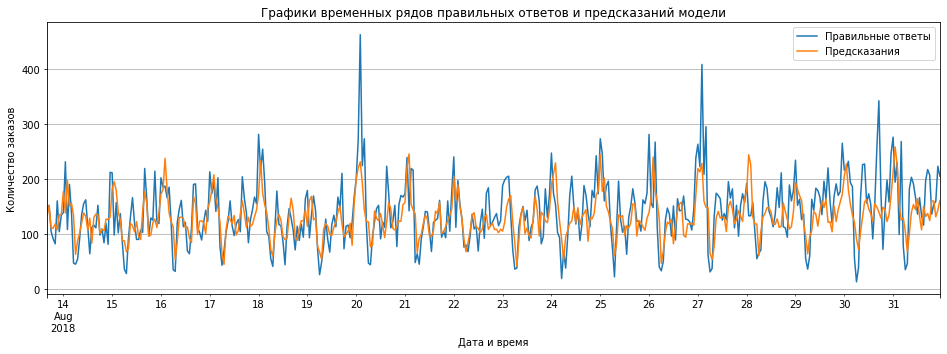

In [37]:
# Визуилизируем предсказания и правильные ответы.
final_result = pd.concat([target_test, predictions], axis=1)
final_result.columns = ['Правильные ответы', 'Предсказания']
final_result.plot(
        kind='line',
        figsize=(16,5),
        grid=True
    )
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.title('Графики временных рядов правильных ответов и предсказаний модели')

Проверим нашу модель на вменяемость.

In [38]:
# Проверим нашу модель предыдущими значениям.
# Сдвинем значения вперед.
predictions_previous = target_test.shift()
# Образовавшееся NaN-значение заменим 
# на последнее из тренировочной выборки.
predictions_previous.iloc[0] = target_train.iloc[-1]
dummy_rmse = (mean_squared_error(target_test, predictions_previous))**0.5
print('RMSE дамми-модели на тестовой выборке составила', dummy_rmse)
if dummy_rmse > rmse:
    print('Наша модель вменяема')
else:
    print('Наша модель невменяема. Требуется доработка')

RMSE дамми-модели на тестовой выборке составила 58.881776776551476
Наша модель вменяема


In [39]:
# Взглянем на атрибут feature_importances.
# Создадим функцию.
def importance(model, features):
    importance = model.feature_importances_
    colums_features = features.columns 
    importance = pd.Series(importance, index=colums_features)
    importance.sort_values(ascending=False).plot(
        kind='bar', x=importance.index, y=importance,
        title='Гистограмма важности признаков'
    )

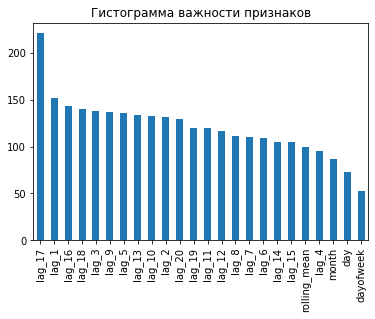

In [40]:
importance(model, features_train)

### Вывод

Выбранная модель градиентного бустинга прошла проверку. Метрика RMSE составила 45,92, значит условие заказчика выполнено.  
Модель проверена на вменяемость при помощью дамми-модели, основанной на предыдущих значениях. Наша модель вменяема.  
В конце исследования мы оценили степень влияния признаков на целевой признак. Любопытно, что среди признаков формата "дата-время" довольно значимым оказался только month. Наиболее значимыми оказались признаки, содержащие в себе отстающие значения.

## Вывод

* Мы загрузили и изучили данные о количестве заказов такси, предоставленные такси-сервисом. Провели ресемплирование временного ряда по одному часу. 
* Провели анализ временного ряда с последующей декомпозицией. Определены тренды и сезонность в четырех временных приближениях (6 месяцев, месяц, неделя, день).
* Мы создали признаки необходимые для создания нашей модели. Разделили датасет на тренировочную и тестовую выборки. Затем рассмотрели четыре модели, настроив их гиперпараметры с целью получения наименьшего значения метрики RMSE. Лучшее значение показала модель градиентного бустинга.
* Протестироволи модель градиентного бустинга. Модель вменяема и обеспечивает заданный уровень качества заказчиком.